# ECE 570 Assignment 4 Exercise

Your Name: Justin Helfman

## Exercise 1: Creating an image denoiser using a CNN autoencoder.
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Add code to `ConcatDataset` dataloader class that will form a paired dataset that contains a noisy image and its original image. i.e Your concatenated dataset should output noisy image and original image just like what image and label is getting extracted from our previous MNIST dataloader. **Note: Your code should not be the same with the instruction since the instruction have paired dataset that contains the labels; here you should only contains the images.**
3. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In [ ]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  # Add addative noise mu=0, stdev=0.3
  # Clip pixels to be between [0, 1]
  def __init__(self, mean, stdev):
    super(AddGaussianNoise, self).__init__()
    self.stdev = stdev
    self.mean = mean
    return
  
  def __call__(self, tensor):
    tensor += torch.randn(tensor.size()) * self.stdev + self.mean
    if torch.min(tensor) < 0: #Adjusting if negative...
      tensor -= torch.min(tensor)
    tensor /= torch.max(tensor) #Adjusting to bounds [0, 1]
    return tensor
    
  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

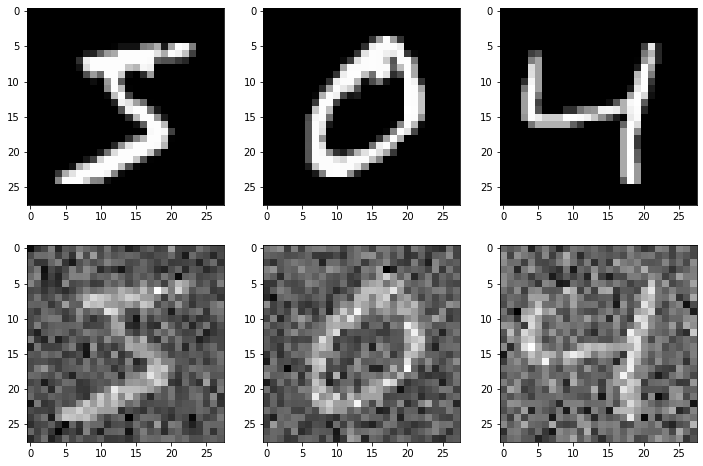

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
  ###########################   <YOUR CODE>  ############################
  
  #Concatenate noisy + original image
  #ignore instructions - labels part
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)

  #########################  <END YOUR CODE>  ############################

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(train_dataset_original[idx][0][0], cmap='gray')
  ax[1,idx].imshow(train_dataset_noisy[idx][0][0], cmap='gray')
fig.show()
#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

Epoch 1: [0/60000] Loss: 29.791534423828125
Epoch 1: [200/60000] Loss: 18.71755599975586
Epoch 1: [400/60000] Loss: 19.049543380737305
Epoch 1: [600/60000] Loss: 19.129852294921875
Epoch 1: [800/60000] Loss: 18.745681762695312
Epoch 1: [1000/60000] Loss: 18.3209228515625
Epoch 1: [1200/60000] Loss: 18.840660095214844
Epoch 1: [1400/60000] Loss: 18.35101890563965
Epoch 1: [1600/60000] Loss: 18.232139587402344
Epoch 1: [1800/60000] Loss: 18.15315818786621
Test result on epoch 1: Avg loss is 18.58056484375
Epoch 2: [0/60000] Loss: 18.284908294677734
Epoch 2: [200/60000] Loss: 18.258573532104492
Epoch 2: [400/60000] Loss: 18.468135833740234
Epoch 2: [600/60000] Loss: 18.86015510559082
Epoch 2: [800/60000] Loss: 18.014245986938477
Epoch 2: [1000/60000] Loss: 18.616186141967773
Epoch 2: [1200/60000] Loss: 18.78330421447754
Epoch 2: [1400/60000] Loss: 18.760669708251953
Epoch 2: [1600/60000] Loss: 18.702224731445312
Epoch 2: [1800/60000] Loss: 18.842599868774414
Test result on epoch 2: Avg lo

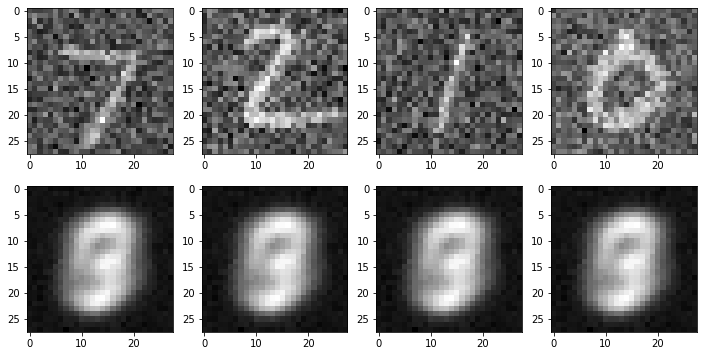

In [ ]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
"""
  1. Build denoising AE with encoders and decoders.  Can add convolutional or transpose layers.  (follow instructions, but add convolutional layer(s))
  2. Make colab in GPU mode
  3. Train with optimizer and loss.  Loss is computed between noisy and clean images.  Loss should bu < 20
  4. Visualize with:
      - 3 test images
      - 3 test images w\ noise
      - 3 reconstructed noisy images
"""
latent_features = 16

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    #encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_conv1 = nn.Conv2d(1, 3, kernel_size=1)
    self.en_conv2 = nn.Conv2d(3, 1, kernel_size=1)
    self.en_fc2 = nn.Linear(in_features=512, out_features=latent_features)

    #decoder
    self.de_fc1 = nn.Linear(in_features=latent_features, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

  def forward(self, x):
    x = x[0]
    #encoding layers
    x = self.en_conv1(x)
    x = self.en_conv2(x)
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = F.relu(self.en_fc2(x))

    #decoding
    x = F.relu(self.de_fc1(x))
    x = torch.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)
    return x

modelAE = AutoEncoder()
optimizer = optim.Adam(modelAE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

def train(epoch):
  modelAE.train()

  for batch_idx, (images, _) in enumerate(train_loader):
    optimizer.zero_grad()
    output = modelAE(images)
    loss = loss_fn(output, images[0])
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0:
      train_losses.append(loss.item()/batch_size_train)
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0:
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

def test(epoch):

  modelAE.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
       output = modelAE(images)
       test_loss += loss_fn(output, images[0]).item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

#Calling of the model:

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2

for epoch in range(1, max_epoch+1):
  train(epoch)
  test(epoch)

#Printing of the images:

batch_idx, (images, _) = next(enumerate(test_loader))
output = modelAE(images).detach().numpy()

fig, ax = plt.subplots(2,4)
fig.set_size_inches(12,6)

for idx in range(4):
  ax[0,idx].imshow(images[0][idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')
  

fig.show()
#########################  <END YOUR CODE>  ############################

## Exercise 2: Build a variational autoencoder that can generate MNIST images

### Task 1: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Print the size of your training and test images.

In [6]:
###########################   <YOUR CODE>  ############################
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(f'The size of the training images is: [{len(train_dataset)}x{len(train_dataset[0])}x{len(train_dataset[0][0])}x{len(train_dataset[0][0][0])}x{len(train_dataset[0][0][0][0])}]')
print(f'The size of the testing images is: [{len(test_dataset)}x{len(test_dataset[0])}x{len(test_dataset[0][0])}x{len(test_dataset[0][0][0])}x{len(test_dataset[0][0][0][0])}]')

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
#########################  <END YOUR CODE>  ############################

The size of the training images is: [60000x2x1x28x28]
The size of the testing images is: [10000x2x1x28x28]


### Task 2: VAE model
Build the VAE (variational autoencoder) model. The general code skeleton is provided here, so you only need to complete the functions in the networks.
(You may need to import certain packages before this code getting implemented)
1. Inside the `reparameterize` function you job is to output a latent vector.You should first calculate the standard deviation `std` from the log value of var `log_var`, then generate the vector in Gaussian distribution with `mu` and `std`. 
2. Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [3]:
latent_feature = 16

class our_VAE(nn.Module):
  def __init__(self):
    super(our_VAE, self).__init__()

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=latent_feature*2)

    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

  def reparameterize(self, mu, log_var, x):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var)
    """
    ###########################   <YOUR CODE>  ############################

    #Job is to output a latent vector.
    #1. Calculate std from log value of log_var
    #2. Generate vector in gaussian distribution with mu and std
    
    std = log_var ** 0.5 #exp(log_var) ** 0.5 #<----- Might be this
    sample = torch.normal(mu, std, size=(int(len(x)/2), 2, 16))
    #########################  <END YOUR CODE>  ############################
    return sample

  
  def forward(self, x):
    """
    :param x: input variables

    You should return a sample with gaussian distribution N(mu, var)
    """
    # encoding layers
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = self.en_fc2(x).view(-1, 2, latent_feature)
    ###########################   <YOUR CODE>  ############################
    # Extract mu and log_var from x
    
    #Output of encoder should be [batch_size x 2 x latent_feature]
    #Need to split tensor in two components (mu, log_var)
    mu = torch.mean(x).item()
    log_var = torch.var(x).item()

    #########################  <END YOUR CODE>  ############################
    z = self.reparameterize(mu, log_var, x)

    # decoding layers
    x = F.relu(self.de_fc1(z))
    x = torch.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)
    
    return x, mu, log_var

### Task 3: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
Basically you need to calculate two part and then add them together.
While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
This reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See `torch.nn.functional.binary_cross_entropy` https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy.
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If both are Gaussian, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$  

The class slides provide some derivation of this.  You can also look at the original paper or this blog post for some more information: [Variational Autoencoder](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

Your task here is simply write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var, and returns the loss.


In [9]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
    
  loss = torch.nn.functional.binary_cross_entropy(input=output, target=images)
  loss -= 0.5*(1+log_var**2-mu**2-math.exp(log_var)**2)

  #########################  <END YOUR CODE>  ############################
  return loss

### Task 4: Train and visualize output
1. Train your model with an appropriate optimizer and above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should show at three pairs of images where each pair consists of an original test image and its VAE reconstructed version.


Epoch 1: [0/60000] Loss: 0.010938970372080803
Epoch 1: [6400/60000] Loss: 0.009129944257438183
Epoch 1: [12800/60000] Loss: 0.00749890087172389
Epoch 1: [19200/60000] Loss: 0.0061521525494754314
Epoch 1: [25600/60000] Loss: 0.005257715005427599
Epoch 1: [32000/60000] Loss: 0.004765584133565426
Epoch 1: [38400/60000] Loss: 0.004620940424501896
Epoch 1: [44800/60000] Loss: 0.004524726886302233
Epoch 1: [51200/60000] Loss: 0.0045799980871379375
Epoch 1: [57600/60000] Loss: 0.004199955612421036
Test result on epoch 1: Avg loss is 0.0002781229850370437
Epoch 2: [0/60000] Loss: 0.004405788611620665
Epoch 2: [6400/60000] Loss: 0.004464971832931042
Epoch 2: [12800/60000] Loss: 0.004288066178560257
Epoch 2: [19200/60000] Loss: 0.004315431695431471
Epoch 2: [25600/60000] Loss: 0.004083706997334957
Epoch 2: [32000/60000] Loss: 0.004223824944347143
Epoch 2: [38400/60000] Loss: 0.0041060736402869225
Epoch 2: [44800/60000] Loss: 0.004523275885730982
Epoch 2: [51200/60000] Loss: 0.004164447076618671


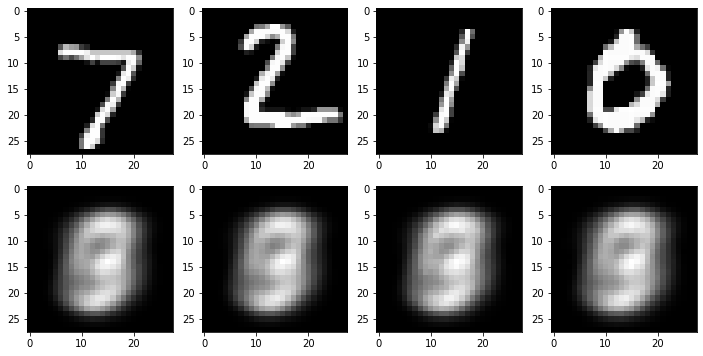

In [10]:
###########################   <YOUR CODE>  ############################

VAE = our_VAE()
optimizer = optim.Adam(VAE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

def train(epoch):
  VAE.train()

  for batch_idx, (images, _) in enumerate(train_loader):
    optimizer.zero_grad()
    output, mu, log_var = VAE(images)
    #print(images.shape)
    #print(output.shape)
    loss = vae_loss(output, mu, log_var, images)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0:
      train_losses.append(loss.item()/batch_size_train)
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0:
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

def test(epoch):

  VAE.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
       output, mu, log_var = VAE(images)
       test_loss += vae_loss(output, mu, log_var, images)

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

#1. Train model with optimizer (Adam) and loss (above)
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2

for epoch in range(1, max_epoch+1):
  train(epoch)
  test(epoch)

#2. Visualize (show three paris of images VAE-Reconstructed)
batch_idx, (images, _) = next(enumerate(test_loader))
output = VAE(images)

fig, ax = plt.subplots(2,4)
fig.set_size_inches(12,6)
for idx in range(4):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[0][idx][0].detach().numpy(), cmap='gray')
  

fig.show()
#########################  <END YOUR CODE>  ###########################